In [1]:
!pip install mxnet gluonts orjson

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 18.6 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1


In [2]:
import gluonts, orjson
from gluonts.mx import Trainer, DeepFactorEstimator, NBEATSEstimator
from gluonts.mx import MQCNNEstimator, MQRNNEstimator, TemporalFusionTransformerEstimator
from gluonts.mx import TransformerEstimator, WaveNetEstimator
import numpy as np
import pandas as pd
#from gluonts.dataset.common import ListDataset
from gluonts.dataset.pandas import PandasDataset
#from gluonts.dataset.split import split
import matplotlib.pyplot as plt

In [10]:
def new_ds(df: pd.DataFrame, freq: str='D') -> gluonts.dataset.Dataset:
  '''Конвертирует pandas dataframe в датасет.
  Входной параметр: df - датафрейм следующего формата: индекс - дата,
    target  - обязательная колонка, содержащая целевое значение.
  Возвращает датасет в виде Dataset.'''
  return PandasDataset(df, target='target', freq=freq)

def new_model(ds: gluonts.dataset.Dataset, pred_len: int, estimator: int=0,
              epochs: int=20, lr: float=1e-3, freq: str='D') -> gluonts.model.Predictor:
  '''Получает обученную модель на датасете.
  Входные параметры:
    ds - датасет для обучения,
    pred_len - длина прогноза,
    estimator - тип оценки (0 - DeepStateEstimator, 1 - DeepFactorEstimator,
      2 - CanonicalRNNEstimator)
    epochs - количество проходов,
    lr - скорость обучения,
    freq - таймфрейм.
  Возвращает объект.'''
  trainer = Trainer(epochs=epochs, learning_rate=lr)
  if estimator == 0:
    estim = DeepFactorEstimator(prediction_length=pred_len, freq=freq,
                                trainer=trainer)
  elif estimator == 1:
    estim = NBEATSEstimator(prediction_length=pred_len, freq=freq, trainer=trainer)
  elif estimator == 2:
    estim = MQCNNEstimator(prediction_length=pred_len, freq=freq, trainer=trainer)
  elif estimator == 3:
    estim = MQRNNEstimator(prediction_length=pred_len, freq=freq, trainer=trainer)
  elif estimator == 4:
    estim = TemporalFusionTransformerEstimator(prediction_length=pred_len,
                                               freq=freq, trainer=trainer)
  return estim.train(ds)

In [11]:
# Загружаем данные
df = pd.read_csv('/content/drive/MyDrive/trainee/Ingate/Ozon/data_ozon.csv',
                 parse_dates=['День'])
# Переименовываем длинные названия с пробелами и кириллическими буквами
dic_ren = {'День': 'timestamp', 'Показы, всего': 'target'}
           #'Показы в поиске и каталоге': 'dyn_real_3'}
df = df.rename(columns=dic_ren)
freq = 'D'
# Отбираем только нужные столбцы
df = df[['timestamp', 'target']]
          #'dyn_real_1', 'dyn_real_2', 'dyn_real_3']]
# Отбираем товары с большим количеством заказов
df = df.groupby('timestamp').target.sum()
# Сортируем по индексу
df.sort_index(inplace=True)
# Делим на обучающую и проверочные выборки
df_train = df.loc[:'2023-05-01']
df_val = df.loc['2023-05-01':]
# Горизонт прогноза будет равен длине проверочной выборки
pred_len = df_val.index.nunique()
ds_train = new_ds(df_train)
# Обучение
model = new_model(ds_train, pred_len, 4)

<ipython-input-11-1af9cd7e8ae0>:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/trainee/Ingate/Ozon/data_ozon.csv',
100%|██████████| 50/50 [00:18<00:00,  2.69it/s, epoch=20/20, avg_epoch_loss=592]


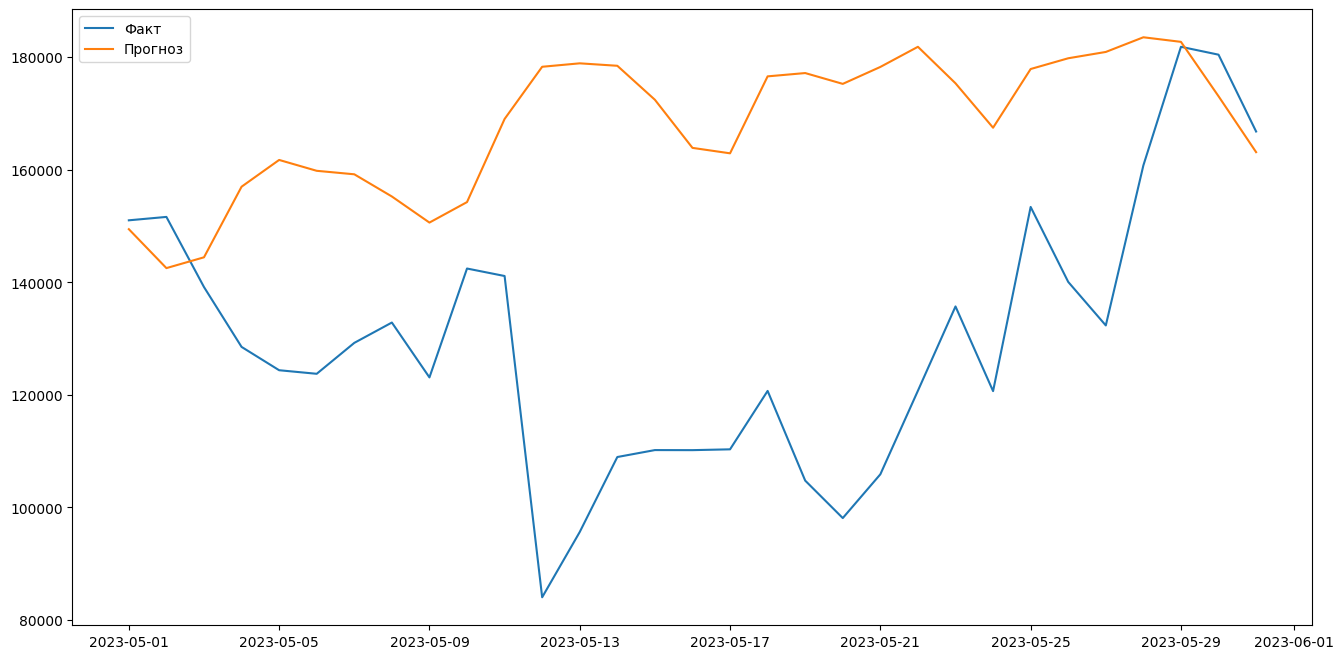

In [12]:
# График
ds_val = new_ds(df_val)
pred = list(model.predict(ds_val))[0]
y_pred = pred.median
y_true = df_val.to_numpy(float)
x = df_val.index.to_numpy()
plt.figure(figsize=(16, 8))
plt.plot(x, y_true, label='Факт')
plt.plot(x, y_pred, label='Прогноз')
plt.legend()
plt.show()